In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import SpanSelector, Slider
import pandas as pd
import numpy as np
import scipy.signal as signal
from scipy.signal import butter
import glob
from os.path import basename, join
import lumicks.pylake as lk

#increase width of notebook:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#set the directory and list the contained .h5 files
direc = "."

print('.h5 files in directory:')
for h5_file in glob.glob(join(direc,"*.h5")):
    print(basename(h5_file))

.h5 files in directory:
20220614-142807 Kymograph 10.h5


In [3]:
# paste the file to be analysed and load it into a pandas dataframe:
h5_name = '20220614-142807 Kymograph 10.h5'
h5_file = lk.File(join(direc, h5_name))

raw_data = pd.DataFrame()
raw_data['# Timestamps (ns)'] = h5_file['Force LF']['Trap 2'].timestamps
raw_data['Trap 1'] = h5_file['Force LF']['Trap 1'].data
raw_data['Trap 2'] = h5_file['Force LF']['Trap 2'].data
raw_data['Distance 1'] = h5_file['Distance']['Distance 1'].data

#add relative time (s) column:
raw_data['Time (s)'] = (raw_data['# Timestamps (ns)'] - raw_data['# Timestamps (ns)'][0])/1000000000
t_interval = raw_data['Time (s)'][1] - raw_data['Time (s)'][0] #calculate the time interval between data points

raw_data

,# Timestamps (ns),Trap 1,Trap 2,Distance 1,Time (s)
0,1655213287381823100,3.443353,4.912351,15.441608,0.000000
1,1655213287448485500,3.371639,4.941759,15.442781,0.066662
2,1655213287515147900,3.309795,4.990031,15.441878,0.133325
3,1655213287581810300,3.375295,5.023679,15.442881,0.199987
4,1655213287648472700,3.469730,5.037117,15.439890,0.266650
...,...,...,...,...,...
1104,1655213360977112700,3.335698,5.004346,15.453846,73.595290
1105,1655213361043775100,3.334510,5.173620,15.448648,73.661952
1106,1655213361110437500,3.502592,4.996501,15.447184,73.728614
1107,1655213361177099900,3.338777,5.108022,15.448780,73.795277


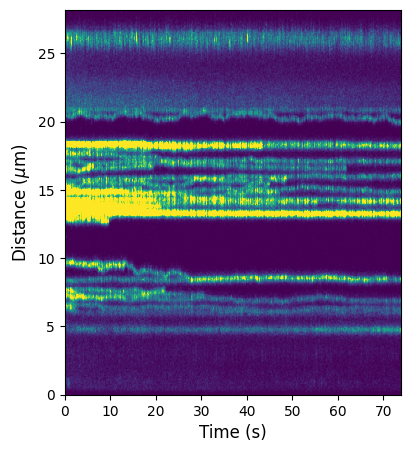

In [4]:
#Plot uncropped kymograph and adjust intensity thresholds for a clear image.  
kymo_name = list(h5_file.kymos)[0]
kymo = h5_file.kymos[kymo_name]
kymo_line_length = kymo.size_um[0]
raw_kymo = kymo.get_image(channel='red')

#set limits to scale colour:
px_min = 0
px_max = 30

fig, ax1 = plt.subplots(1, figsize=(8,5))

ax1.imshow(raw_kymo, aspect=3, cmap='viridis', 
           extent=[raw_data['Time (s)'].min(), raw_data['Time (s)'].max(), 0, kymo_line_length],
           norm=mpl.colors.Normalize(vmin=px_min, vmax=px_max, clip=False))
ax1.set_xlabel('Time (s)', fontsize=12)
ax1.set_ylabel('Distance ($\mu$m)', fontsize=12)
plt.show()

<IPython.core.display.Javascript object>


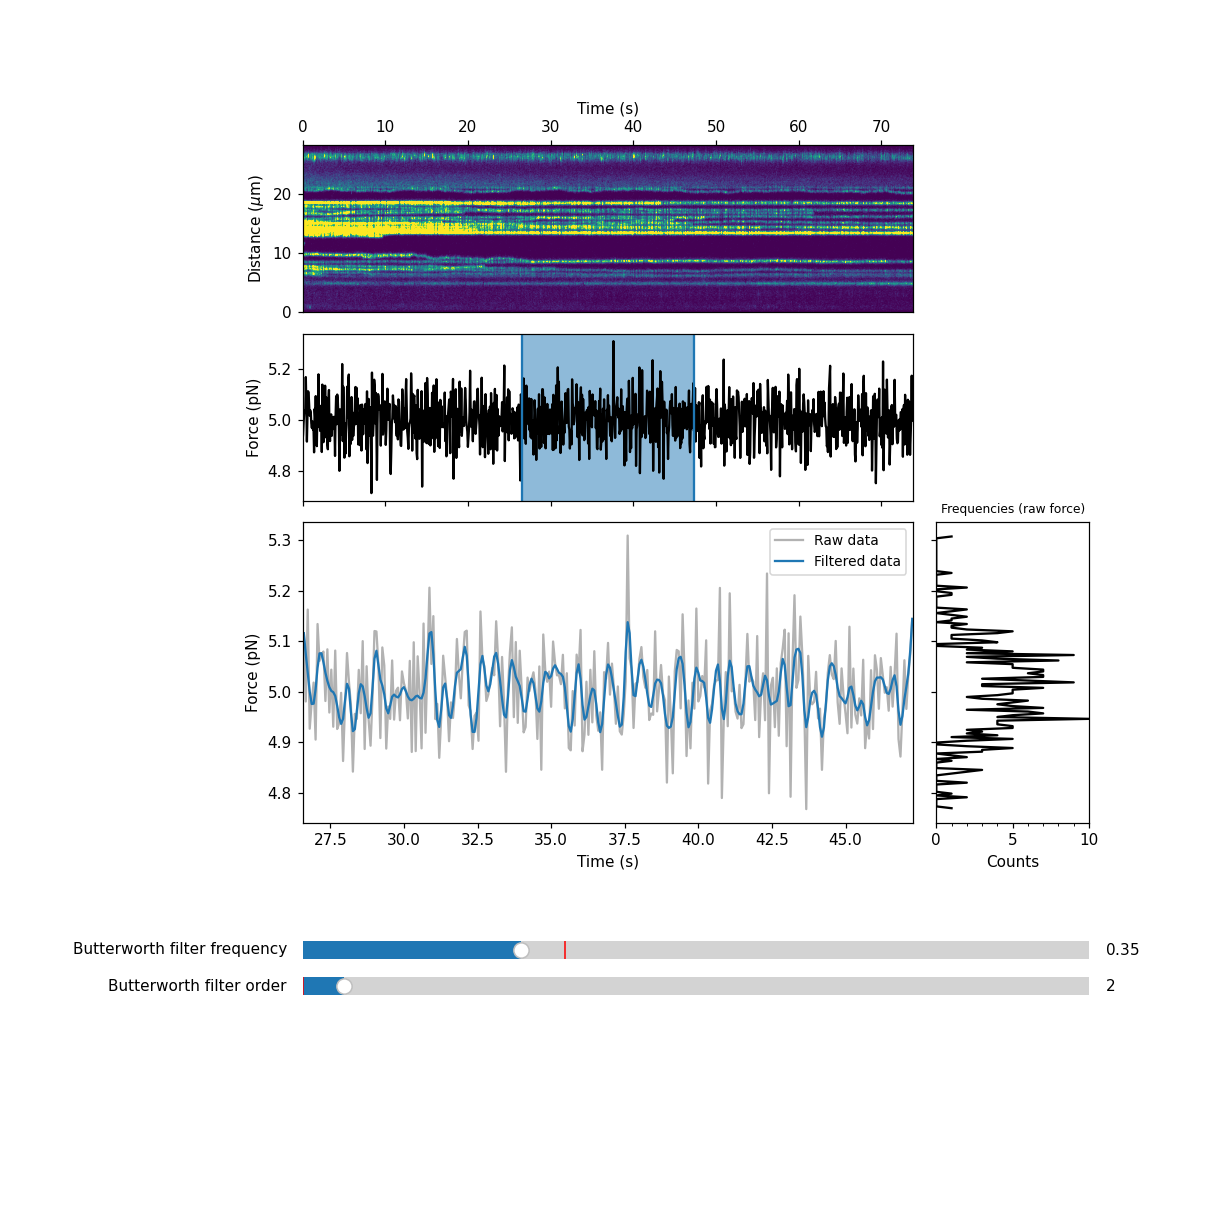

In [5]:
# This cell plots an interactive data cropper for slicing force/distance data to a time region of interest 
# and adds a dataframe column of filtered values for the selected force or distance channel:
%matplotlib notebook

channel = 'Trap 2'  # Select which channel to plot in the data cropper (cropping of the dataframe to the selected time region will apply to all Force & Distance channels)

if 'Distance' in channel:
    y_label = 'Distance ($\mu$m)'    
elif 'Trap' in channel:
    y_label =  'Force (pN)'

#initialise filtered data column in dataframe:
butter_order =  1
butter_freq = 0.4

sos = butter(butter_order, butter_freq, 'lp', output='sos')
raw_data['Filtered '+channel] =  signal.sosfiltfilt(sos, raw_data[channel])

#initialise plot:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(11, 11), gridspec_kw={'width_ratios': [4, 1], 'height_ratios': [1, 1, 1.8]})
fig.subplots_adjust(hspace=0.1, wspace=0.06)

ax1.imshow(raw_kymo, cmap='viridis', aspect='auto',
           extent=[raw_data['Time (s)'].min(), raw_data['Time (s)'].max(), 0, kymo_line_length],
           norm=mpl.colors.Normalize(vmin=px_min, vmax=px_max, clip=False))
ax1.set_ylabel('Distance ($\mu$m)')
ax1.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax1.set_xlabel("Time (s)")  
ax1.xaxis.set_label_position('top') 
#ax1.xaxis.tick_top()

ax2.axis('off')

ax3.plot(raw_data['Time (s)'], raw_data[channel], color='black')
#ax3.set_title('Crop data by click/dragging to select a region in the upper plot', fontsize=10)
ax3.set_ylabel(y_label)

ax3.get_shared_x_axes().join(ax1, ax3)
ax3.set_xticklabels([])

ax4.axis('off')

ax5.set_xlabel("Time (s)")
ax5.set_ylabel(y_label)

#the histogram on ax6 is optional, but I find it useful for some downsteam analysis steps.
ax6.set_xlabel("Counts")
ax6.set_title('Frequencies (raw force)', fontsize=8)

ax6.get_shared_y_axes().join(ax5, ax6)
ax6.set_yticklabels([])
ax6.minorticks_on()
ax6.yaxis.set_tick_params(which='minor', bottom=False)

plot2, = ax5.plot([], [], label='Raw data', color='black', alpha=.3)
plot3, = ax5.plot([], [], label='Filtered data')

plot4, = ax6.plot([], [], color='black') #I'm not sure how to make an active histogram or bar plot, so doing this as a standard plt.plot()

# adjust the main plot to make room for the sliders
fig.subplots_adjust(left=0.25, bottom=0.32)

# Make a horizontal slider to set the filter frequency:
init_freq = 0.4
ax_freq = fig.add_axes([0.25, 0.2, 0.65, 0.03])
freq_slider = Slider(
    ax=ax_freq,
    label='Butterworth filter frequency',
    valmin=0.1,
    valmax=1,
    valinit=init_freq,
    valstep=0.05
)

# Make a horizontal slider to set the filter order:
init_order = 1
ax_order = fig.add_axes([0.25, 0.17, 0.65, 0.03])
order_slider = Slider(
    ax=ax_order,
    label='Butterworth filter order',
    valmin=1,
    valmax=20,
    valinit=init_order,
    valstep=1
)

def onselect(xmin, xmax):
    sos = butter(butter_order, butter_freq, 'lp', output='sos')
    raw_data['Filtered '+channel] =  signal.sosfiltfilt(sos, raw_data[channel])
    global data
    data = raw_data.loc[(raw_data['Time (s)'] > xmin) & (raw_data['Time (s)'] < xmax)]

    region_x = data['Time (s)']
    region_y = data[channel]
    region_y2 = data['Filtered '+channel]
    
    global counts, bins
    counts, bins = np.histogram(data[channel], bins=150)
    global bin_mids
    bin_mids = (bins[1:] + bins[:-1])/2
    
    region_min = data[channel].min()
    region_max = data[channel].max()
    region_range = data[channel].max() - data[channel].min()

    if len(region_x) >= 2:
        plot2.set_data(region_x, region_y)
        ax5.set_xlim(xmin, xmax)
        ax5.set_ylim(region_min- (region_range*0.05), region_max + (region_range*0.05))
        ax5.legend(fontsize=9)
        plot3.set_data(region_x, region_y2)
        
        ax6.set_xlim(0, counts.max())
        plot4.set_data(counts, bin_mids)
        fig.canvas.draw_idle()

span = SpanSelector(
    ax3,
    onselect,
    "horizontal",
    useblit=True,
    props=dict(alpha=0.5, facecolor="tab:blue"),
    interactive=True,
    drag_from_anywhere=True
)
# Set useblit=True on most backends for enhanced performance.

# The functions to be called anytime a slider's value changes 
def update_freq(val):
    global butter_freq
    butter_freq = val
    sos = butter(butter_order, butter_freq, 'lp', output='sos')
    data['Filtered '+channel] = signal.sosfiltfilt(sos, data[channel])
    region_x = data['Time (s)']
    region_y2 = data['Filtered '+channel]
    plot3.set_data(region_x, region_y2)
    fig.canvas.draw_idle()
    
    global init_freq
    init_freq = val
    
def update_order(val):
    global butter_order
    butter_order = val   
    sos = butter(butter_order, butter_freq, 'lp', output='sos')
    data['Filtered '+channel] = signal.sosfiltfilt(sos, data[channel])
    region_x = data['Time (s)']
    region_y2 = data['Filtered '+channel]
    plot3.set_data(region_x, region_y2)
    fig.canvas.draw_idle()
    
    global init_order
    init_order = val

freq_slider.on_changed(update_freq)
order_slider.on_changed(update_order)

plt.show()

In [6]:
data

,# Timestamps (ns),Trap 1,Trap 2,Distance 1,Time (s),Filtered Trap 2
399,1655213313980120700,3.302205,5.116271,15.445502,26.598298,5.116282
400,1655213314046783100,3.320900,4.981046,15.439402,26.664960,5.074998
401,1655213314113445500,3.216292,5.163056,15.442568,26.731622,5.037231
402,1655213314180107900,3.321115,4.927109,15.435344,26.798285,5.000826
403,1655213314246770300,3.329349,4.979999,15.439668,26.864947,4.976067
...,...,...,...,...,...,...
705,1655213334378815100,3.415214,5.062749,15.437425,46.996992,4.985837
706,1655213334445477500,3.362213,4.966311,15.437678,47.063654,5.010162
707,1655213334512139900,3.277784,5.034562,15.433615,47.130317,5.036715
708,1655213334578802300,3.333552,5.074648,15.434622,47.196979,5.082546
